In [12]:
#2017/4/15 完成訓練模組
#2017/4/21 加入RUC曲線
#考慮自由中國非文藝類，投稿數量前10名的作者
#實驗流程：獲得內文 -> 文本特徵向量建立 -> SMOTE平衡文本量 
# -> GridSearchCV找尋最佳參數並交叉驗證 -> 建立預測報表/點陣圖/預測模型
#特徵採用詞性組合、情態詞+V組合、否定&程度組合
#一般常用的特徵有高頻詞、bigram&trigram、標點符號、豐富度
import codecs
import os
from collections import OrderedDict,defaultdict,Counter
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from matplotlib.font_manager import FontProperties
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from imblearn.under_sampling import OneSidedSelection 

condicate_author = ['雷震','殷海光','夏道平','傅正','龍平甫','蔣勻田','朱伴耘','胡適','羅鴻詔']

condicate_author_path = "D:\\課業相關\\論文資料\\SVM\\condicate_author\\" #候選作者文本
normal_feature_path = "D:\\課業相關\\論文資料\\SVM\\language_feature\\" #常用特徵
paper_feature_path = "D:\\課業相關\論文資料\\SVM\\language_feature\\二版\\" #論文提出特徵
unknow_author_path = "D:\\課業相關\\論文資料\\SVM\\unknow_author\\" #未知作者文本

print ("library and path OK")

library and path OK


In [13]:
#建立作者索引，提取各作者文章內容及索引
author_index = defaultdict(int)
for index,name in enumerate(condicate_author): #建立作者索引
    author_index[name] = index

author_index = OrderedDict(sorted(author_index.items(), key=lambda t: t[1])) #作者索引排序(依文本數量高到低)

for name,index in author_index.items():
    print (name+':'+str(index),end=' ')
print ()
    
content_list = [] #所有作者文本內容(未處理)
article_label = [] #各文本label，也就是作者索引

a_c = defaultdict(int)

for file in os.listdir(condicate_author_path):
    with codecs.open(condicate_author_path+file,'rb','utf8') as f:
        
        if file.split('_')[0] not in condicate_author:
            continue
        
        '''if a_c[file.split('_')[0]] > 19:
            continue'''
        
        title = f.readline()
        content = f.readline().strip()
        
        '''if len(content.split()) <= 2000:
            continue'''
        
        content_list.append(content)
        
        article_label.append(author_index[file.split('_')[0]])
        
        '''if len(content.split()) <= 2000:
            content_list.append(content)
            article_label.append(author_index[file.split('_')[0]])'''
        
        #a_c[file.split('_')[0]] += 1
        
print ('共有'+str(len(content_list))+'篇文章')
print (Counter(article_label))

雷震:0 殷海光:1 夏道平:2 傅正:3 龍平甫:4 蔣勻田:5 朱伴耘:6 胡適:7 羅鴻詔:8 
共有433篇文章
Counter({0: 89, 1: 80, 2: 63, 3: 48, 4: 41, 5: 30, 6: 29, 7: 27, 8: 26})


In [3]:
#建立特徵
feature = [] #特徵
feature_file = '自由中國前100個VH+N.csv' 
select_path = paper_feature_path
with codecs.open(select_path+feature_file,'rb','utf8') as f: #抓取基準特徵
    for i in f.readlines():
        if i.strip() != '':
            feature.append(i.strip().split(',')[0])

#單以作者間為母體
'''feature_select = defaultdict(int)

def format_check(word):
    if '(' in word and 'CATEGORY' not in word and word != '' and word[0] != '(' and word.split('(')[1] != '':
        return True
    return False
        
def pos_check(word1,word2,pos1,pos2):
    if word1.split('(')[1][0] == pos1 and word2.split('(')[1][0] == pos2:
        return True
    return False
        
for file in content_list:
    content = file.split()
    for i in range(len(content)-1):
        if format_check(content[i]) and format_check(content[i+1]):
            if content[i].split('(')[1][:2] == 'VH' and content[i+1].split('(')[1][0] == 'N' \
                    and content[i+1].split('(')[1].split(')')[0] != 'Neu':
                feature_select[content[i]+content[i+1]] += 1

feature_select = sorted(feature_select.items(), key=lambda d:d[1], reverse = True)

for i,(f,n) in enumerate(feature_select):
    if i == 100:
        break
    feature.append(f)'''
    
print (len(feature))   
print (feature)

100
['自由(VH)中國(Nc)', '實際(VH)上(Ng)', '民主(VH)政治(Na)', '自由(VH)世界(Nc)', '自由(VH)主義(Na)', '民主(VH)國家(Na)', '獨裁(VH)者(Na)', '大(VH)批(Nf)', '公營(VH)事業(Na)', '中立(VH)主義(Na)', '值得(VH)我們(Nh)', '死(VH)後(Ng)', '實際(VH)政治(Na)', '自由(VH)民主(Na)', '反共(VH)人士(Na)', '和平(VH)攻勢(Na)', '實際(VH)情形(Na)', '無形(VH)中(Ng)', '大(VH)問題(Na)', '國營(VH)事業(Na)', '新(VH)憲法(Na)', '先進(VH)國家(Na)', '安全(VH)理事會(Na)', '反共(VH)力量(Na)', '平均(VH)每(Nes)', '新(VH)民主(Na)', '自由(VH)國家(Na)', '獨立(VH)運動(Na)', '獨裁(VH)政治(Na)', '小(VH)事(Na)', '結束(VHC)後(Ng)', '小(VH)國(Na)', '小(VH)黨(Na)', '激進(VH)社會黨(Nb)', '自由(VH)競爭(Na)', '對立(VH)法院(Nc)', '新(VH)中國(Nc)', '自由(VH)思想(Na)', '解散(VHC)國會(Nc)', '不成(VH)問題(Na)', '獨立(VH)後(Ng)', '新(VH)辦法(Na)', '重大(VH)問題(Na)', '自由(VH)經濟(Na)', '統一(VHC)問題(Na)', '大(VH)政黨(Na)', '勝利(VH)後(Ng)', '獨立(VH)宣言(Na)', '真(VH)象(Na)', '安全(VH)措施(Na)', '實際(VH)問題(Na)', '黨化(VHC)教育(Na)', '反共(VH)者(Na)', '美(VH)蘇(Nc)', '積極(VH)方面(Na)', '畢業(VH)後(Ng)', '小(VH)資產(Na)', '停戰(VH)協定(Na)', '必要(VH)時(Ng)', '開始(VH)時(Ng)', '利(VH)亞(Nc)', '密切(VH)關係(Na)', '不成(VH)其(Nep)', '消極(VH)方面(Na)'

In [9]:
#將文章轉換為特徵向量，並平衡作者文本數量(以最多為基準)
def line_vec(line): #將文章轉換為特徵向量並回傳
    temp_feature = defaultdict(int)
    
    #line = [line[i].split('(')[0] for i in range(len(line))] #詞頻
    #line = [line[i].split('(')[0]+line[i+1].split('(')[0] for i in range(len(line)-1)] #bigram
    #line = [line[i].split('(')[0]+line[i+1].split('(')[0]+line[i+2].split('(')[0] for i in range(len(line)-2)] #trigram
    #line = [line[i]+line[i+1] for i in range(len(line)-1)] #詞性組合
    line = [line[i]+line[i+1] for i in range(len(line)-1)] + [line[i]+line[i+1]+line[i+2] for i in range(len(line)-2)] #2~3詞性組合
    
    for i in line:
        if i in feature:
            temp_feature[i] += 1
    
    return temp_feature

aa_feature = np.zeros((len(content_list),len(feature)),np.float64)
muti_author = defaultdict(list) #將向量分類

for index,element in enumerate(content_list): #依序將文章轉換為特徵向量
    line = element.split()
    temp_feature = line_vec(line)
    
    for i,j in enumerate(feature):
        aa_feature[index, i] = round(temp_feature[j] * 1000000 / len(line),3) #取相對頻率
        
    muti_author[article_label[index]].append(list(aa_feature[index]))
    
'''for i,e in muti_author.items():
    for j in e:
        print (i,max(j),Counter(j))
    print ()'''

for index in range(1,len(muti_author)): #將分類後的向量內容數量平均，也就是文本數量一致

    min_target = -1
    min_num = 1000
    
    for i,e in muti_author.items():
        if len(e) <= min_num:
            min_num = len(e)
            min_target = i
            
    if len(muti_author[0]) == min_num: #取到文本數量與最大等數值為止，預設最大是第0個
        break
    
    X_t = muti_author[0]+muti_author[min_target]
    y_t = [0]*len(muti_author[0])+[min_target]*len(muti_author[min_target])
    
    X_t, y_t = SMOTE(random_state=0).fit_sample(X_t,y_t) #SMOTE
    muti_author[min_target] = X_t[len(muti_author[0]):]


'''for a_i in range (len(muti_author)):
    for index in range(a_i+1,len(muti_author)):

        X_t = muti_author[a_i]+muti_author[index]
        y_t = [a_i]*len(muti_author[a_i])+[index]*len(muti_author[index])

        X_t, y_t = OneSidedSelection(random_state=0).fit_sample(X_t,y_t) #OSS
        
        if Counter(y_t)[a_i] <= 40 and Counter(y_t)[index] <= 40:
            continue
        
        muti_author[index] = [X_t[j] for j in [i for i,e in enumerate(y_t) if e == index]]
        muti_author[a_i] = [X_t[j] for j in [i for i,e in enumerate(y_t) if e == a_i]]
        
max_target = 0
max_num = -1
for k,v in muti_author.items():
    if len(v) > max_num:
        max_num = len(v)
        max_target = k
        
for index in range(1,len(muti_author)): #將分類後的向量內容數量平均，也就是文本數量一致

    min_target = -1
    min_num = 1000
    
    for i,e in muti_author.items():
        if len(e) <= min_num:
            min_num = len(e)
            min_target = i
            
    if len(muti_author[max_target]) == min_num: #取到文本數量與最大等數值為止，預設最大是第0個
        break
    
    X_t = muti_author[max_target]+muti_author[min_target]
    y_t = [max_target]*len(muti_author[max_target])+[min_target]*len(muti_author[min_target])
    
    X_t, y_t = SMOTE(random_state=0).fit_sample(X_t,y_t) #SMOTE
    muti_author[min_target] = X_t[len(muti_author[max_target]):]'''

    
X = [] #處理後文本向量
y = [] #處理後文本label

#X,y = OneSidedSelection(random_state=0).fit_sample(aa_feature,article_label)

for k,v in muti_author.items():
    for l in v:
        X.append(l)
    y += [k]*len(v)
    
X = np.array(X)
y = np.array(y)

#X,y = OneSidedSelection(random_state=0).fit_sample(X,y)

print ('X:',X.shape)
print ('y:',y.shape)
print ('資料準備已完成')
print (Counter(list(y)))

zero_count = []
for i in range(len(feature)):
    zero_count.append(Counter(X[:,i].tolist())[0]) #找出特徵中0的出現次數
print (zero_count)

X: (801, 100)
y: (801,)
資料準備已完成
Counter({0: 89, 1: 89, 2: 89, 3: 89, 4: 89, 5: 89, 6: 89, 7: 89, 8: 89})
[565, 508, 633, 654, 723, 638, 677, 711, 784, 750, 728, 696, 693, 745, 737, 732, 752, 765, 742, 785, 789, 797, 754, 772, 795, 771, 734, 764, 758, 770, 760, 743, 770, 798, 794, 770, 789, 770, 785, 753, 790, 787, 764, 782, 752, 799, 783, 777, 775, 788, 770, 784, 765, 760, 709, 782, 781, 772, 754, 772, 798, 780, 749, 710, 771, 769, 778, 760, 768, 773, 790, 795, 776, 761, 730, 783, 753, 787, 764, 770, 780, 779, 788, 764, 787, 778, 777, 771, 770, 794, 798, 773, 789, 773, 767, 762, 787, 790, 799, 790]


In [ ]:
from sklearn import preprocessing 

X = preprocessing.scale(X)
print (X[:10])

In [5]:
#建立預測模型
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0) #分割訓練與測試資料

print (feature_file)
print ()

start = time.time()

#MultinomialNB
'''from sklearn.naive_bayes import MultinomialNB

param_grid = {
    'fit_prior': [True,False]
}

clf = GridSearchCV(MultinomialNB(), n_jobs=-1, param_grid=param_grid, cv=10)
clf.fit(X_train,y_train)'''


#決策樹
'''param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

tclf = DecisionTreeClassifier(max_features= 'sqrt')
clf = GridSearchCV(tclf, param_grid=param_grid, cv=10)
clf.fit(X_train, y_train)'''


#SVM
'''tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], #SVM
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}] #候選參數

clf = GridSearchCV(svm.SVC(C=1,probability=True), tuned_parameters, n_jobs=-1, cv=10) #使用交叉驗證並找出最佳參數
clf.fit(X_train, y_train)'''

#隨機森林樹
param_grid = { 
    'n_estimators': [200, 700], #1000和700結果差不多
    'max_features': ['auto', 'sqrt', 'log2']
}

rfc = RandomForestClassifier(n_jobs=-1, oob_score = True, class_weight = 'balanced')
clf = GridSearchCV(rfc, param_grid=param_grid, cv=10)
clf.fit(X_train, y_train)

end = time.time()
print ('耗費時間：',end-start,'秒')
print ()

print("Best parameters set found on development set:")
print()
print(clf.best_params_) #印出最佳參數
print()
print ('最佳預測精準度：',clf.best_score_)
print ()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.") 
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred)) #顯示報表(pred可能和predict_proba不一致，這邊假設為一致)
print()

自由中國前100個VH+N.csv

耗費時間： 93.7634162902832 秒

Best parameters set found on development set:

{'n_estimators': 700, 'max_features': 'log2'}

最佳預測精準度： 0.7125

Grid scores on development set:

0.688 (+/-0.062) for {'n_estimators': 200, 'max_features': 'auto'}
0.700 (+/-0.062) for {'n_estimators': 700, 'max_features': 'auto'}
0.694 (+/-0.069) for {'n_estimators': 200, 'max_features': 'sqrt'}
0.695 (+/-0.055) for {'n_estimators': 700, 'max_features': 'sqrt'}
0.695 (+/-0.063) for {'n_estimators': 200, 'max_features': 'log2'}
0.713 (+/-0.050) for {'n_estimators': 700, 'max_features': 'log2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.50      0.50      0.50        20
          1       0.71      0.45      0.56        11
          2       0.67      0.52      0.59        23
          3       0.71      0.59      0.65        17
      

In [ ]:
from sklearn.metrics import hamming_loss
print (hamming_loss(y_true, y_pred))

In [ ]:
#比較個演算法
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

print (feature_file)

gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

def NB_pre(pre):
    clf = GridSearchCV(pre, n_jobs=-1, param_grid={}, cv=10)
    clf.fit(X_train,y_train)
    return clf.best_score_
    

#測試分類
print('Gaussian 分類:', NB_pre(gnb))
print('Multinomial 分類:', NB_pre(mnb))
print('Bernoulli 分類:', NB_pre(bnb))

param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

tclf = DecisionTreeClassifier(max_features= 'sqrt')
clf = GridSearchCV(tclf, param_grid=param_grid, cv=10)
clf.fit(X_train, y_train)
print('DecisionTree 分類:', clf.best_score_)

param_grid = { 
    'n_estimators': [200, 700], #1000和700結果差不多
    'max_features': ['auto', 'sqrt', 'log2']
}

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True)
clf = GridSearchCV(rfc, n_jobs=-1, param_grid=param_grid, cv=10)
clf.fit(X_train, y_train)
print('RandomForest 分類:', clf.best_score_)

In [6]:
#重要特徵選取
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(clf.best_estimator_, prefit=True)
X_new = model.transform(X)
print (X_new.shape)

zero_count = []
for i in range(X_new.shape[1]):
    zero_count.append(Counter(X_new[:,i].tolist())[0]) #找出特徵中0的出現次數
print (zero_count)

print ([feature[i] for i in range(len(feature)) if model.get_support()[i]])

(801, 35)
[565, 508, 633, 654, 723, 638, 677, 711, 750, 728, 696, 693, 737, 732, 752, 765, 742, 734, 758, 743, 752, 760, 709, 754, 749, 710, 771, 730, 753, 764, 764, 771, 773, 767, 762]
['自由(VH)中國(Nc)', '實際(VH)上(Ng)', '民主(VH)政治(Na)', '自由(VH)世界(Nc)', '自由(VH)主義(Na)', '民主(VH)國家(Na)', '獨裁(VH)者(Na)', '大(VH)批(Nf)', '中立(VH)主義(Na)', '值得(VH)我們(Nh)', '死(VH)後(Ng)', '實際(VH)政治(Na)', '反共(VH)人士(Na)', '和平(VH)攻勢(Na)', '實際(VH)情形(Na)', '無形(VH)中(Ng)', '大(VH)問題(Na)', '自由(VH)國家(Na)', '獨裁(VH)政治(Na)', '小(VH)國(Na)', '統一(VHC)問題(Na)', '美(VH)蘇(Nc)', '積極(VH)方面(Na)', '必要(VH)時(Ng)', '不成(VH)其(Nep)', '消極(VH)方面(Na)', '大(VH)大地(Na)', '增加(VHC)其(Nep)', '大(VH)帽子(Na)', '嚴重(VH)問題(Na)', '止(VH)此(Nep)', '重要(VH)因素(Na)', '自由(VH)意志(Na)', '孤立(VHC)主義(Na)', '強大(VH)反對黨(Na)']


In [ ]:
#未知作者預測
print (' '.join([str(i)+'.'+e for i,e in enumerate(condicate_author)])) #印出作者
print ()
 
print ('最佳預測精準度：',clf.best_score_)
print ()

for file in os.listdir(unknow_author_path):
    pred_y = np.zeros((1,len(feature)),np.float64)
    with codecs.open(unknow_author_path+file,'rb','utf8') as f:
        head = f.readline().strip()
        content = f.readline().strip().split()

        temp_feature = line_vec(content)

        for i,j in enumerate(feature):
            pred_y[0][i] = round(temp_feature[j] * 1000000 / len(content),3)

    print (head)
    print ('預測作者：'+str(clf.predict(pred_y)[0])+'.'+condicate_author[clf.predict(pred_y)[0]])
    print ([round(i,3) for i in clf.predict_proba(pred_y)[0].tolist()])
    print ()

In [ ]:
#畫出點陣圖
X_reduced = PCA(n_components=2).fit_transform(X) #使用PCA降維
colors = ['white', 'red', 'lime', 'cyan', 'orange', 'black', 'blue', 'purple', 'yellow']
for i in range(len(colors)):
    if i in [4,5,6,8]:
        continue
    x_p = X_reduced[:, 0][y == i]
    y_p = X_reduced[:, 1][y == i]
    plt.scatter(x_p, y_p, c=colors[i])
name = [condicate_author[i] for i in [0,1,2,3,7]]
plt.legend(name, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., \
           prop = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) ) #顯示中文
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

In [ ]:
#預測模型儲存
from sklearn.externals import joblib
joblib.dump(clf, 'C:\\Users\\user\\Desktop\\預測資料\\random forest\\自程.pkl') 
clf = joblib.load('C:\\Users\\user\\Desktop\\預測資料\\random forest\\自程.pkl') 
print (clf.best_score_)

In [ ]:
#印出特徵重要性
print (len(clf.best_estimator_.feature_importances_))
feature_score = list(clf.best_estimator_.feature_importances_)
#print (feature_score)
#print (feature_score.index(max(feature_score)))
feature_value,feature_index = zip(*sorted(zip(feature_score,[i for i,e in enumerate(feature_score)]),reverse=True)) #排序
print (feature_index[:10])
print ([feature[i] for i in feature_index[:10]])
#print (feature_value[:10])
#print ([i for i in zip(y,X[:,feature_index[0]])][:10])
print ([i for i in zip(article_label,aa_feature[:,feature_index[0]])][:5])
s = aa_feature[:,[i for i in feature_index[:10]]]
print (s.shape)
#print (aa_feature[:,feature_index[0]])
with codecs.open('C:\\Users\\user\\Desktop\\前10名特徵向量.csv','wb','utf8') as g:
    for i,e in enumerate(list(s)):
        g.write(str(article_label[i])+','+','.join(list(map(str,e)))+'\r\n')

0.94


C:\Users\user\Anaconda2\envs\py35\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


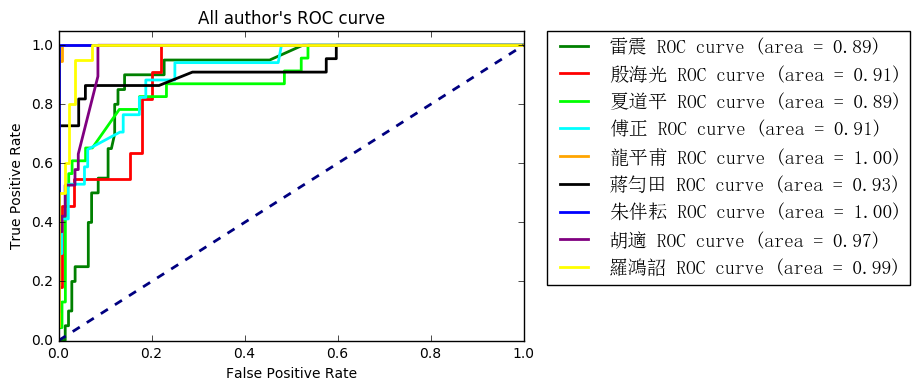

In [7]:
#AUC計算(待修正)
y_true2, y_pred2 = y_test, clf.predict_proba(X_test)
#y_true2, y_pred2 = y_test, clf.predict(X_test)

colors = ['green', 'red', 'lime', 'cyan', 'orange', 'black', 'blue', 'purple', 'yellow']
lw = 2
tag = []

mean = 0.0

for i in range(len(condicate_author)):
    fpr, tpr,thresholds = roc_curve(y_true2, y_pred2[:,i], pos_label=i)
    #fpr, tpr,thresholds = roc_curve([1 if j == i else 0 for j in y_true2], [1 if j == i else 0 for j in y_pred2])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i], lw=lw)
    tag.append('%s ROC curve (area = %0.2f)' % (condicate_author[i],roc_auc))  
    mean += roc_auc
    
print (round(mean/len(condicate_author),2))
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(tag, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., \
           prop = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)) #顯示中文
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All author\'s ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#印出決策樹
#graphviz用conda安裝後要建立環境變數
from sklearn import tree
import pydotplus 
from IPython.display import Image 

dot_data = tree.export_graphviz(clf.best_estimator_[0], out_file=None,
                                filled=True,
                                 max_depth=3) 
graph = pydotplus.graph_from_dot_data(dot_data)
#graph.write_pdf("C:\\Users\\user\\Desktop\\graph.pdf") 
Image(graph.create_png())
#graph.write_png("C:\\Users\\user\\Desktop\\dtree.png")

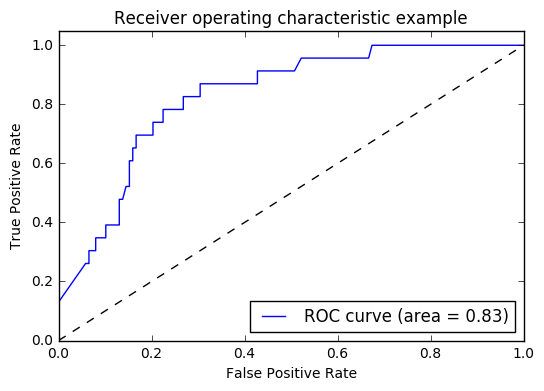

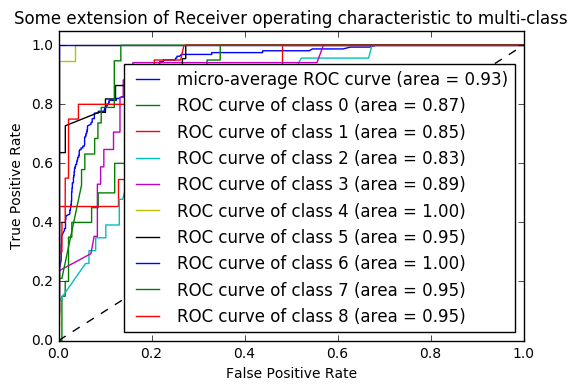

In [10]:
#針對mutlclass的ROC圖(嘗試中)
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
y = label_binarize(y, classes=[i for i in range(len(condicate_author))])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(clf.best_estimator_)
#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()